# Part 2: Automatic differentiation

In [1]:
import numpy as np
import random
np.random.seed(seed=42) # to have same results each time
import matplotlib.pyplot as plt


import importlib
import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset

### Question 1: implement the relu function and its VJP in the format above. Using the finite difference equation (slide 13), make sure that the VJP is correct numerically.

In [2]:
def relu(x):
  """
  Args:
    x: an array

  Returns:
    - value of the function ReLU(x) 
    - function vjp to easily compute vjp of ReLU
  """
  value = np.maximum(x,0) #by defintion of the ReLU function 
  
  def vjp(u):
    relu_derivative = (x > 0) * 1 #by definition of the derivative and ReLU function 
    vjp_wrt_x = np.multiply(u,relu_derivative) #using slides 27 of the course
    return vjp_wrt_x,  

  return value, vjp

Now, we will create some functions to numerically check if the function defined above (and others ones later) are correct.

In [3]:
def test_vjp(f, x, u, eps=1e-3):
  """
  Args:
    f: a function returning a tuple of size 2: array and vjp
    x: an array of size n 
    eps: numerical value (very small)
    u: an array of size m 

  Returns:
    numerical_vjp
  """
  
  def e(i): # to define each direction in the space
    basis_vector = np.zeros(len(x))
    basis_vector[i] = 1
    return basis_vector
  
  Jacobian = np.zeros((len(f(x)[0]),len(x)))
  for i in range (len(x)):
    Jacobian[:,i] = (f(x + eps * e(i))[0] - f(x)[0]) / eps #finite difference
  
  return np.dot(Jacobian.T,u)

In [4]:
#test implementation 
# we define some values for x and u, they must same dimension because for ReLU space of inputs and outputs are the same
x = np.linspace(start = -2, stop = 2, num = 40)
u = np.linspace(start = -5, stop = 2, num = 40)

implemented_vjp = relu(x)[1](u)[0]
relu_numerical_vjp = test_vjp(relu, x, u, eps=1e-3)

print("The numeric method gives for the VJP:")
print(relu_numerical_vjp)


The numeric method gives for the VJP:
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.41025641 -1.23076923 -1.05128205 -0.87179487
 -0.69230769 -0.51282051 -0.33333333 -0.15384615  0.02564103  0.20512821
  0.38461538  0.56410256  0.74358974  0.92307692  1.1025641   1.28205128
  1.46153846  1.64102564  1.82051282  2.        ]


In [5]:
print("The implemented method gives for the VJP:")
print(implemented_vjp)

The implemented method gives for the VJP:
[-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -1.41025641 -1.23076923 -1.05128205 -0.87179487
 -0.69230769 -0.51282051 -0.33333333 -0.15384615  0.02564103  0.20512821
  0.38461538  0.56410256  0.74358974  0.92307692  1.1025641   1.28205128
  1.46153846  1.64102564  1.82051282  2.        ]


The two methods give the same results indeed.

### Question 2: reusing dot and relu, implement a 2-layer MLP with a relu activation


In [6]:
#we import dot from the google doc
def dot(W, x):
  """
  Args:
    W: an a matrix of shape (n1,n)
    x: an array of shape n 

  Returns:
    - value of the function dot(W,x) 
    - function vjp to easily compute vjp of the dot product
  """
  value = np.dot(W, x)

  def vjp(u):
    return np.outer(u, x), np.dot(W.T,u)

  return value, vjp

In [7]:
def mlp2(x, W1, W2):
    """
    This function defines a MLP-2 architecture with ReLU function activation

    Args:
        x: an array of shape n 
        W1: an a matrix of shape (n1,n)
        W2: an a matrix of shape (1,n1)

    Returns:
        - value of the function mlp2(x, W1, W2)
        - function vjp to easily compute vjp of mlp2 archietcture 
    """

    x1 = dot(W1,x)[0] #1st linear layer 
    x2 = relu(x1)[0] #ReLU activation 
    x3 = dot(W2,x2)[0] #2nd linear layer
    value = x3

    def vjp(u):
        
        vjp_jacobian_dot_W2 = dot(W2,x2)[1](u) 
        vjp_wrt_W2 = vjp_jacobian_dot_W2[0] # we keep the 1st vjp, with respect to W2

        vjp_jacobian_dot_W2_wrt_x2 = vjp_jacobian_dot_W2[1] # we keep the 2nd vjp, with respect to x2
        vjp_jacobian_relu_wrt_x1 = relu(x1)[1](vjp_jacobian_dot_W2_wrt_x2)[0]

        vjp_jacobian_dot_W1 =  dot(W1,x)[1](vjp_jacobian_relu_wrt_x1) 
        vjp_wrt_W1 = vjp_jacobian_dot_W1[0] # we keep the 1st vjp, with respect to W1
        vjp_wrt_x = vjp_jacobian_dot_W1[1] # we keep the 2nd vjp, with respect to x
        
        return vjp_wrt_x,vjp_wrt_W1, vjp_wrt_W2

    return value, vjp

### Question 3: implement the squared loss VJP

In [8]:
def squared_loss(y_pred, y):
    """
    This function defines squared-loss between 2 vectors

    Args:
        y_pred: a scalar
        y: a scalar 
        
    Returns:
        - value of the function squared_loss(y_pred, y)
        - function vjp to easily compute vjp of the squared loss
    """

    residual = y_pred - y
    value = 0.5 * np.sum(residual ** 2)

    def vjp(u):
        vjp_y_pred = np.multiply(residual,u)
        vjp_y = -np.multiply(residual,u)
        return vjp_y_pred, vjp_y
    
    # The code requires every output to be an array.
    return np.array([value]), vjp

### Question 4: implement the loss by composing mlp2 and squared_loss


In [9]:
def loss(x, y, W1, W2):
    """
    This function defines the loss, by combining previous function squared_loss and mlp2

    Args:
        x: an array of shape n 
        y: an array of shape n 
        W1: an a matrix of shape (n1,n)
        W2: an a matrix of shape (1,n1)
        
    Returns:
        - value of the function loss(x, y, W1, W2)
        - function vjp to easily compute vjp of the loss
    """

    y_pred = mlp2(x, W1, W2)[0]
    value = squared_loss(y_pred, y)[0]

    def vjp(u):
        
        vjp_squared_loss = squared_loss(y_pred, y)[1](u)
        vjp_wrt_y = vjp_squared_loss[1] # we keep the vjp with respect to y 

        vjp_mlp2 = mlp2(x, W1, W2)[1](vjp_squared_loss[0])

        vjp_wrt_W2 = vjp_mlp2[2] # we keep the vjp with respect to W2
        vjp_wrt_W1 = vjp_mlp2[1] # we keep the vjp with respect to W1
        vjp_wrt_x = vjp_mlp2[0] # we keep the vjp with respect to Wx
        
        return vjp_wrt_x, vjp_wrt_y, vjp_wrt_W1, vjp_wrt_W2

    return value, vjp

Now let's numerically test our architecture

In [10]:
#check the gradient for x coordinate 

def test_architecture_vjp(f,x,y,W1,W2,u, eps=1e-3): 

    """
    Args:
        f: a function returning a tuple of size 2: array and vjp
        x: an array of size n 
        eps: numerical value (very small)
        u: an array of size m 

    Returns:
        numerical_vjp

    """
    
    def e(i): # to define each direction in the space
        basis_vector = np.zeros(len(x))
        basis_vector[i] = 1
        return basis_vector
  
    Jacobian = np.zeros((len(f(x,y,W1,W2)[0]),len(x)))
    for i in range (len(x)):
        Jacobian[:,i] = (f(x + eps * e(i),y,W1,W2)[0] - f(x,y,W1,W2)[0]) / eps #finite difference
  
    return np.dot(Jacobian.T,u) 

In [11]:
# we define some values for x and u, they must same dimension because for ReLU space of inputs and outputs are the same
m = 5 #size 
k = 10 #size of the ouput vector for the MLP

x = np.linspace(start = -2, stop = 2, num = 40) #size of the input vector
y = np.linspace(start = -2, stop = 2, num = k) #size of the output vector
u = np.random.rand(1) #size 1 for vjp because f will output a scalar

W1 = np.random.rand(m,len(x))
W2 = np.random.rand(k,m)

relu_numerical_vjp = test_architecture_vjp(loss,x,y,W1,W2,u, eps=1e-3)
implemented_vjp = loss(x, y, W1, W2)[1](u)[0]

print("The numeric method gives for the VJP:")
print(relu_numerical_vjp)

The numeric method gives for the VJP:
[16.04505928  9.91200029  5.58862923  4.74737583 12.21629471 13.86878034
 12.30645815  7.59373855 11.96999804  9.19819874  7.38265823 11.13201473
  8.60483474 17.65606679  7.53824422 13.24675525 11.19865447 10.18888991
  8.32207167  9.29397093  7.73841677 13.31167587 13.22816866 11.3341041
  7.63295551 13.95047329 13.93247314  6.50169319  4.40605946  9.02690877
 10.16465822 15.82647781 14.90742599 14.32600886 11.50377891 16.81575735
 13.76914738 16.01980159 15.46865053 14.18225387]


In [12]:
print("The implemented method gives for the VJP:")
print(implemented_vjp)

The implemented method gives for the VJP:
[16.04259184  9.91108597  5.5883257   4.74714672 12.21490809 13.86684627
 12.30487919  7.59311114 11.96865213  9.19741378  7.38206557 11.13082566
  8.60410097 17.6530607   7.53767522 13.24511224 11.19743421 10.1879015
  8.32130853  9.29309954  7.73779845 13.31003075 13.22653151 11.33281267
  7.6323905  13.94866386 13.93061635  6.50128786  4.40587776  9.02601196
 10.16367308 15.82409896 14.90530978 14.32393694 11.502476   16.81307263
 13.7673902  16.01737479 15.46640677 14.18034267]


2 methods are really close but don't give exactly same results (because of numerical approximations).

### Question 5: implement an MLP with an arbitrary number of layers.


In [13]:
def mlp(x, *args):
    """
    This function defines a MLP architecure with ReLU function activation

    Args:
        x: an array of shape n 
        *args: matrix of each layer. ATTENTION: dimension should match for dot product

    Returns:
        - value of the function mlp(x, *args)
        - function vjp to easily compute vjp of mlp archietcture 
    """
    n_layers = len(args)
    hidden_x = [] #store intermediate values along forward pass
    input = x 
    
    for layer in range(n_layers-1):
        x_current_layer =  [0,0] 

        x = dot(args[layer],x)[0] #linear layer
        x_current_layer[0] = x
        
        x = relu(x)[0] #ReLU activation 
        x_current_layer[1] = x
        
        hidden_x.append(x_current_layer) #store value both after linear transfo and relu activation
    
    value = dot(args[n_layers-1],hidden_x[n_layers-2][1])[0] #no activation on last layer

    def vjp(u):
        
        list_of_vjp = []

        #last layer
        vjp_dot_last_layer = dot(args[n_layers-1],hidden_x[n_layers-2][1])[1](u) 
        vjp_wrt_weights = vjp_dot_last_layer[0] # we keep the 1st vjp, with respect to weights
        vjp_wrt_x = vjp_dot_last_layer[1] 

        list_of_vjp.insert(0,vjp_wrt_weights)
        
        for layer in range(n_layers-2,0,-1):
            vjp_relu_wrt_x = relu(hidden_x[layer][0])[1](vjp_wrt_x)[0] #backward relu
            vjp_dot_current_layer = dot(args[layer],hidden_x[layer-1][1])[1](vjp_relu_wrt_x) #backward dot 
            vjp_wrt_weights = vjp_dot_current_layer[0] #keep weights
            vjp_wrt_x = vjp_dot_current_layer[1] 

            list_of_vjp.insert(0,vjp_wrt_weights)
        
        #1st layer
        vjp_relu_wrt_x = relu(hidden_x[0][0])[1](vjp_wrt_x)[0] #backward relu
        vjp_dot_current_layer = dot(args[0],input)[1](vjp_relu_wrt_x) #backward dot 
        vjp_wrt_weights = vjp_dot_current_layer[0] #keep weights
        vjp_wrt_x = vjp_dot_current_layer[1] 

        list_of_vjp.insert(0,vjp_wrt_weights)
        list_of_vjp.insert(0,vjp_wrt_x)

        return list_of_vjp

    return value, vjp

#should be ok: to check
def loss_general_MLP(x, y, *args):
    """
    This function defines the loss, by combining previous function squared_loss and mlp2

    Args:
        x: an array of shape n 
        y: an array of shape n 
        *args: matrix of each layer. ATTENTION: dimension should match for dot product
        
    Returns:
        - value of the function loss(x, y, *args)
        - function vjp to easily compute vjp of the loss
    """

    y_pred = mlp(x, *args)[0]
    value = squared_loss(y_pred, y)[0]

    def vjp(u):
        
        vjp_squared_loss = squared_loss(y_pred, y)[1](u)
        vjp_wrt_y = vjp_squared_loss[1] # we keep the vjp with respect to y 

        vjp_mlp = mlp(x, *args)[1](vjp_squared_loss[0])

        list_of_vjp = []
        list_of_vjp.append(vjp_mlp[0])# add vjp wrt to x 
        list_of_vjp.append(vjp_wrt_y)# add vjp wrt to y

        list_of_vjp = list_of_vjp + vjp_mlp[1:] #add vjp wrt to weights 
        
        return list_of_vjp

    return value, vjp



### Question 6: implement SGD to train your MLP on a dataset of your choice. Study the impact of depth (number of layers) and width (number of hidden units).



Let's implement our autodiff on a simple dataset with a neural network using mlp2.
The dataset generated is an easy one with 200 samples and 2 features. A linear model is sufficient to capture it's complexity.

In [14]:
#Generate dataset with 2 features by row, with same distribution
nsamples = 200
range_uniform = 5 
sigma = 2
xtrain, ytrain = generate_dataset(nsamples, range_uniform, sigma)
xtest, ytest = generate_dataset(nsamples, range_uniform, sigma)

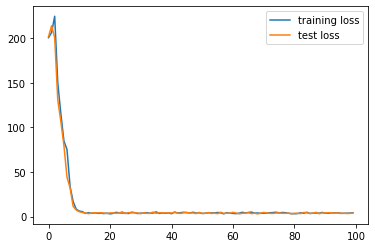

Minimal training error: 3.099317795942237
Minimal test error: 3.046711879571872


In [15]:
#test with mlp2
learning_rate = 1e-4
nepochs = 100

input_dim = xtrain.shape[1]
hidden_dim_1 = 2
hidden_dim_2 = 2


#weights initialisation
W1 = np.random.normal(loc=0, scale=1./np.sqrt(input_dim),
          size=(hidden_dim_1, input_dim))
W2 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_1),
          size=(hidden_dim_2, hidden_dim_1))

training_loss, test_loss = [], []

for epoch in range(nepochs):

    train_err = []
    for n in range(nsamples):
        random_index = np.random.randint(nsamples)
        loss_train_it = loss(xtrain[random_index], ytrain[random_index], W1, W2)[0]
        vector_for_starting_backward = 1 #because we use SGD, if batch would need of vector of len = batch_size
        grad_W1 = loss(xtrain[random_index], ytrain[random_index], W1, W2)[1](vector_for_starting_backward)[2]
        grad_W2  =  loss(xtrain[random_index], ytrain[random_index], W1, W2)[1](vector_for_starting_backward)[3]
        W1 = W1 - learning_rate*grad_W1
        W2 = W2 - learning_rate*grad_W2
        train_err.append(loss_train_it)

    test_err = []
    for n in range(nsamples):
        random_index = np.random.randint(nsamples)
        loss_test_it = loss(xtrain[random_index], ytrain[random_index], W1, W2)[0]
        test_err.append(loss_test_it)

    training_loss.append(np.array(train_err).mean())
    test_loss.append(np.array(test_err).mean())

plt.plot(np.array(training_loss), label='training loss')
plt.plot(np.array(test_loss), label='test loss')
plt.legend()
plt.show()

print("Minimal training error: " + str(min(training_loss)))
print("Minimal test error: " + str(min(test_loss)))

The data we generated is simple (linear regression on both coordinates on x to get y), so there is no surprise the mlp2 should be able to figure out "good" parameters. This is what we get here, both training loss and test loss goes towards 0 at what seems to be a geometric rate. Besides, we can observe the stochastic component of SGD on the long trail with small bump. 
As the dataset is simple, number of neurons is not so important: we achieve good results even with 2 neurons per layer.

Nevertheless, interestingly the initialisation of weights play a crucial role. Indeed, even on such a simple dataset, a "bad" initialisation results in getting SGD stuck at local minima with poor performances. This illustrates the power of NN: they need to be given extra care to be efficient, either trough appropriate weight initialisation or through advanced SGD techniques (momentum, diagonal scalinl,...) or both. 

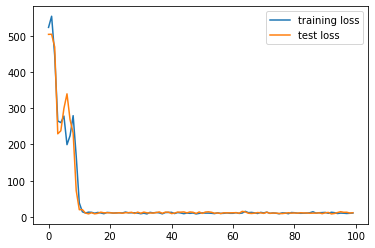

Minimal training error: 8.421000892277153
Minimal test error: 8.433359211163365


In [23]:
#test with mlp general architecture
learning_rate = 1e-4
nepochs = 100

#test with 4 layers
input_dim = xtrain.shape[1]
hidden_dim_1 = 2
hidden_dim_2 = 3
hidden_dim_3 = 4
hidden_dim_4 = 5


#weights initialisation
W1 = np.random.normal(loc=0, scale=1./np.sqrt(input_dim),
          size=(hidden_dim_1, input_dim))
W2 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_1),
          size=(hidden_dim_2, hidden_dim_1))
W3 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_2),
          size=(hidden_dim_3, hidden_dim_2))
W4 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_3),
          size=(hidden_dim_4, hidden_dim_3))

training_loss, test_loss = [], []

for epoch in range(nepochs):

    train_err = []
    for n in range(nsamples):
        random_index = np.random.randint(nsamples)
        loss_train_it = loss_general_MLP(xtrain[random_index], ytrain[random_index], W1, W2, W3, W4)[0]
        vector_for_starting_backward = 1 #because we use SGD, if batch would need of vector of len = batch_size
        grad = loss_general_MLP(xtrain[random_index], ytrain[random_index], W1, W2,  W3, W4)[1](vector_for_starting_backward)
        grad_W1 = grad[2]
        grad_W2  =  grad[3]
        grad_W3 = grad[4]
        grad_W4  =  grad[5]
        W1 = W1 - learning_rate*grad_W1
        W2 = W2 - learning_rate*grad_W2
        W3 = W3 - learning_rate*grad_W3
        W4 = W4 - learning_rate*grad_W4

        train_err.append(loss_train_it)

    test_err = []
    for n in range(nsamples):
        random_index = np.random.randint(nsamples)
        loss_test_it = loss_general_MLP(xtrain[random_index], ytrain[random_index], W1, W2, W3, W4)[0]
        test_err.append(loss_test_it)

    training_loss.append(np.array(train_err).mean())
    test_loss.append(np.array(test_err).mean())

plt.plot(np.array(training_loss), label='training loss')
plt.plot(np.array(test_loss), label='test loss')
plt.legend()
plt.show()

print("Minimal training error: " + str(min(training_loss)))
print("Minimal test error: " + str(min(test_loss)))

For our dataset the number of layers shouldn't be too high. Indeed, the more complex the nework is the higer the risk it get stucks in local minima.
Here with 3 hidden layers, we see we get stuck a few epochs in local minima but the networks managed to get out of it.